In [1]:
!pip install phik -q
!pip install shap -q
!pip install category_encoders -q
!pip install lightgbm -q
!pip install --upgrade scikit-learn -q
!pip install catboost -q

##Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import pylab
import scipy.stats as stats
import warnings
import random
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from datetime import datetime, timedelta

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     RandomizedSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (recall_score,
                             precision_score,
                             accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             roc_auc_score,
                             f1_score,
                             make_scorer)
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   MultiLabelBinarizer,
                                   OneHotEncoder)
from sklearn.impute import (SimpleImputer,
                            KNNImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

from itertools import chain
import ast
import re
import phik
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(12, 12)})
#sns.set_palette("viridis")

pd.set_option('display.max_columns', None)

RANDOM_STATE = 15
TEST_SIZE = 0.25

##Загрузка данных

In [4]:
df_purchas = pd.read_csv('/content/apparel-purchases.csv', parse_dates=['date'])


In [5]:
df_messages = pd.read_csv('/content/apparel-messages.csv', parse_dates=['date', 'created_at'])
df_target = pd.read_csv('/content/apparel-target_binary.csv')

In [6]:
df_purchas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [7]:
df_purchas.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [8]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [9]:
df_messages.head(20)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [10]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [11]:
df_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


##Исследовательнский анализ и создание признаков

In [12]:
df_purchas_pivot = pd.pivot_table(df_purchas, values=['quantity' , 'price'], index=['client_id'], aggfunc="sum").reset_index()

In [13]:
df_purchas_pivot.client_id.duplicated().sum()

0

После агрегации по client_id получилось 49849 строк, также как и в файле с целевым признаком. Соответсвенно дупликатов нет.

In [14]:
def cat_vis(df, cat):
    sns.barplot(x=df[cat].value_counts().index,
                y=df[cat].value_counts(),
                #data=df,
               )
    plt.title(f'График распределения {cat}', weight='bold')
    plt.xlabel('Кол-во вернувшихся покупателей')
    plt.show()
    return df[cat].value_counts()

In [15]:
def numeric_analysis(df, column, annot):
    # выводим таблицу со статистикой и считаем усы боксплота
    stat = df[column].describe()
    print(stat)
    up_whisker = stat['75%'] + 1.5 * (stat['75%'] - stat['25%'])
    low_whisker = stat['25%'] - 1.5 * (stat['75%'] - stat['25%'])

    print(f'\nВерхний ус: {round(up_whisker, 2)} \nНижний ус: {round(low_whisker, 2)} \
    \nМедианное значение: {df[column].median()}')

    # строим ящик с усами и гистограмму признака
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], orient="h", ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist, bins=100, kde=True)
    plt.axvline(df[column].mean(), color='r', linestyle='-', label=f'Среднее значение: {round(df[column].mean(), 2)}')
    plt.axvline(df[column].median(), color='g', linestyle='--', label=f'Медианное значение: {round(df[column].median(), 2)}')
    ax_box.set(xlabel='')
    ax_hist.legend(loc='best')
    ax_box.set_title(f'График распределения {annot}', weight='bold')
    plt.show()

count    202208.000000
mean          1.006483
std           0.184384
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

Верхний ус: 1.0 
Нижний ус: 1.0     
Медианное значение: 1.0


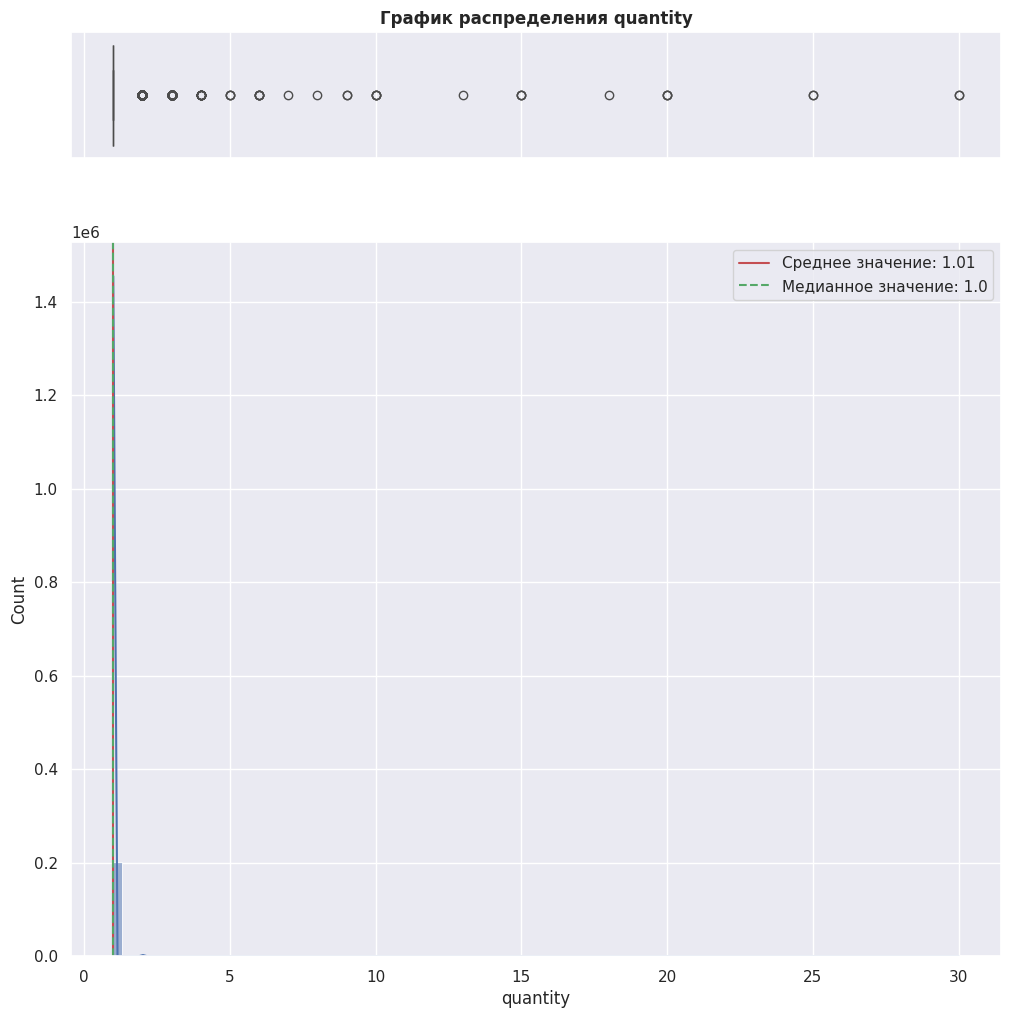

In [16]:
numeric_analysis(df_purchas, 'quantity', 'quantity')

In [17]:
df_purchas[df_purchas['quantity'] == 30]

,client_id,quantity,price,category_ids,date,message_id
37005,1515915625548883766,30,2.0,"['5562', '5597', '5691', '889']",2022-09-06,1515915625548883766-6283-6316e248bbbf9
158373,1515915625594593699,30,2.0,"['5562', '5597', '5691', '889']",2023-07-12,1515915625468268596-13482-64ae724c9316b


count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

Верхний ус: 3719.5 
Нижний ус: -1668.5     
Медианное значение: 987.0


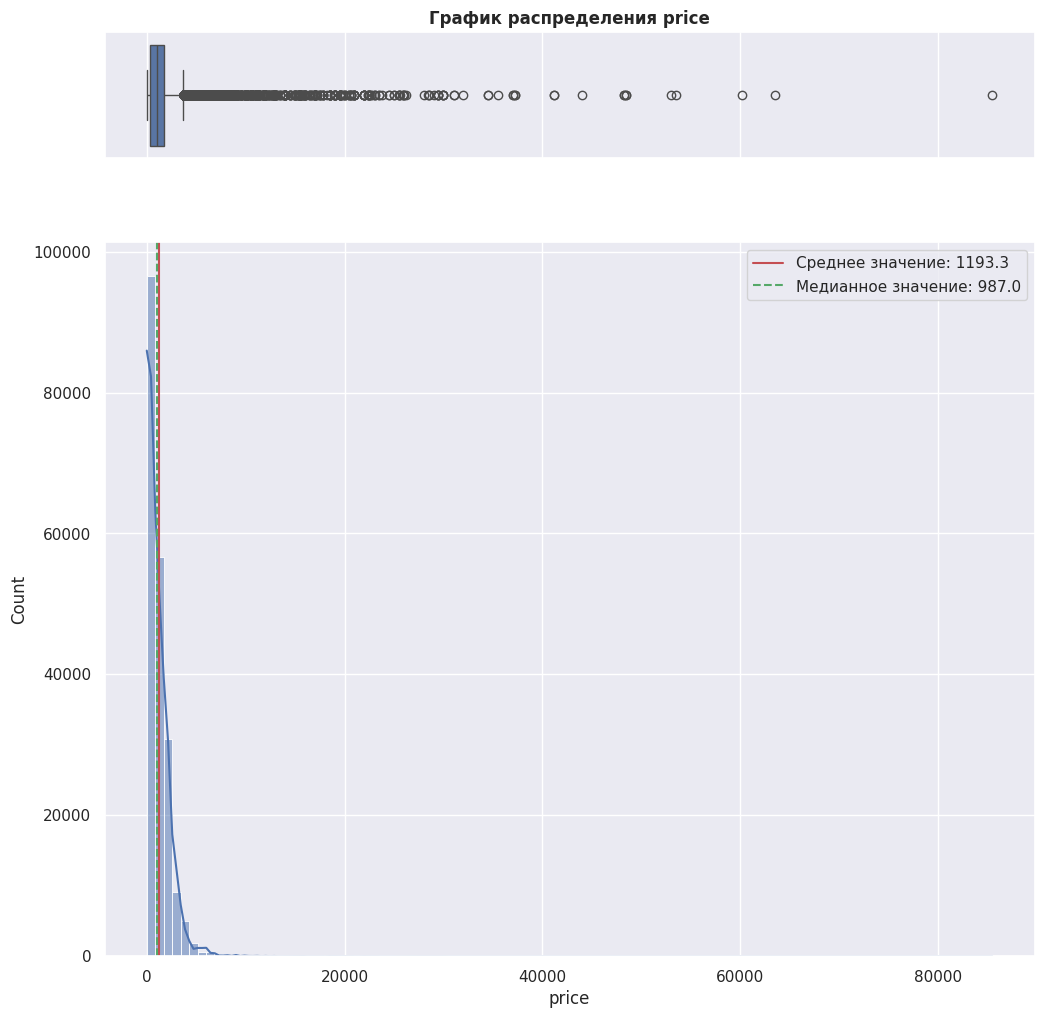

In [18]:
numeric_analysis(df_purchas, 'price', 'price')

In [19]:
df_purchas[df_purchas['price'] > 80000]

,client_id,quantity,price,category_ids,date,message_id
186736,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711


In [20]:
df_purchas[df_purchas['price'] == 1]

,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
32063,1515915625490679651,1,1.0,"['4', '28', '44', '1594']",2022-08-19,1515915625490679651-5922-62ff354e68cd3
32064,1515915625490679651,1,1.0,"['4', '28', '44', '1594']",2022-08-19,1515915625490679651-5922-62ff354e68cd3
32283,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
...,...,...,...,...,...,...
198702,1515915625615134152,1,1.0,"['2', '18', '61', '660']",2024-02-02,1515915625615134152-14590-65bcac271717b
199509,1515915625505063729,1,1.0,[],2024-02-08,1515915625505063729-14582-65bb5a2b9adcc
199510,1515915625505063729,1,1.0,[],2024-02-08,1515915625505063729-14582-65bb5a2b9adcc
201246,1515915625558967191,1,1.0,[],2024-02-14,1515915625980158750-14649-65cca1c3cc334


In [21]:
df_purchas_pivot['mean_price'] = df_purchas_pivot['price'] / df_purchas_pivot['quantity']
df_purchas_pivot['total_price'] = df_purchas_pivot['price'] * df_purchas_pivot['quantity']

In [22]:
df_purchas_pivot.rename(columns={'price': 'sum_price',
                                      'quantity': 'sum_quantity'}, inplace=True)
df_purchas_pivot

,client_id,sum_price,sum_quantity,mean_price,total_price
0,1515915625468060902,6993.0,7,999.000000,48951.0
1,1515915625468061003,16235.0,7,2319.285714,113645.0
2,1515915625468061099,299.0,1,299.000000,299.0
3,1515915625468061100,2098.0,2,1049.000000,4196.0
4,1515915625468061170,33601.0,19,1768.473684,638419.0
...,...,...,...,...,...
49844,1515915626010261344,8994.0,6,1499.000000,53964.0
49845,1515915626010266132,1818.0,2,909.000000,3636.0
49846,1515915626010439406,198.0,2,99.000000,396.0
49847,1515915626010443527,1999.0,1,1999.000000,1999.0


count    4.984900e+04
mean     4.140694e+04
std      4.853769e+05
min      1.000000e+00
25%      2.199000e+03
50%      6.996000e+03
75%      2.339100e+04
max      9.419428e+07
Name: total_price, dtype: float64

Верхний ус: 55179.0 
Нижний ус: -29589.0     
Медианное значение: 6996.0


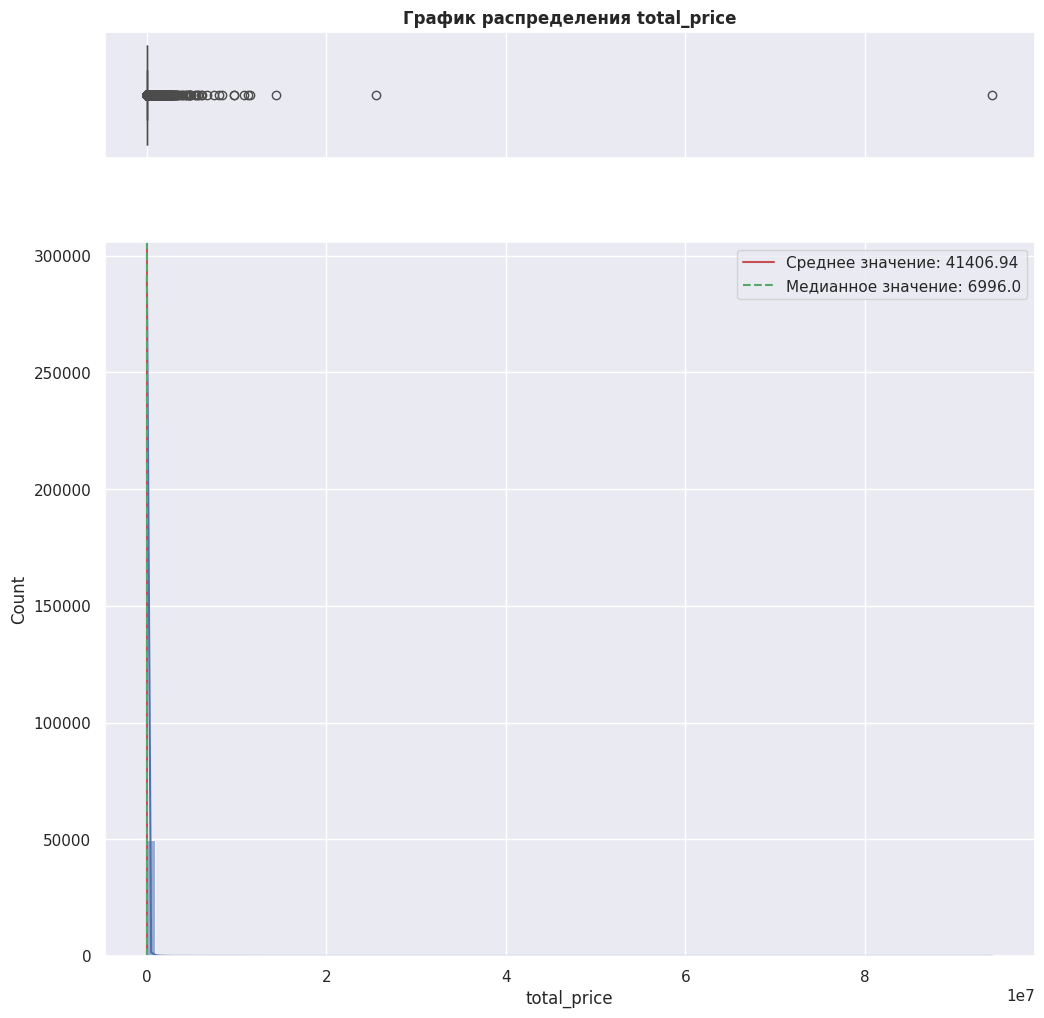

In [23]:
numeric_analysis(df_purchas_pivot, 'total_price', 'total_price')

In [24]:
df_purchas_price_grouped = df_purchas.groupby('client_id')['price'].agg(['min', 'max']).reset_index()

In [25]:
df_purchas_price_grouped.rename(columns = {'min': 'min_price',
                                           'max': 'max_price'}, inplace=True)

In [26]:
df_purchas_price_grouped['diff_min_max_price'] = df_purchas_price_grouped['max_price'] - df_purchas_price_grouped['min_price']

In [27]:
df_purchas_price_grouped.head()

,client_id,min_price,max_price,diff_min_max_price
0,1515915625468060902,199.0,1999.0,1800.0
1,1515915625468061003,1749.0,3499.0,1750.0
2,1515915625468061099,299.0,299.0,0.0
3,1515915625468061100,1049.0,1049.0,0.0
4,1515915625468061170,7.0,2699.0,2692.0


count    49849.000000
mean      1792.131377
std       1647.320646
min          1.000000
25%        910.000000
50%       1499.000000
75%       2199.000000
max      85499.000000
Name: max_price, dtype: float64

Верхний ус: 4132.5 
Нижний ус: -1023.5     
Медианное значение: 1499.0


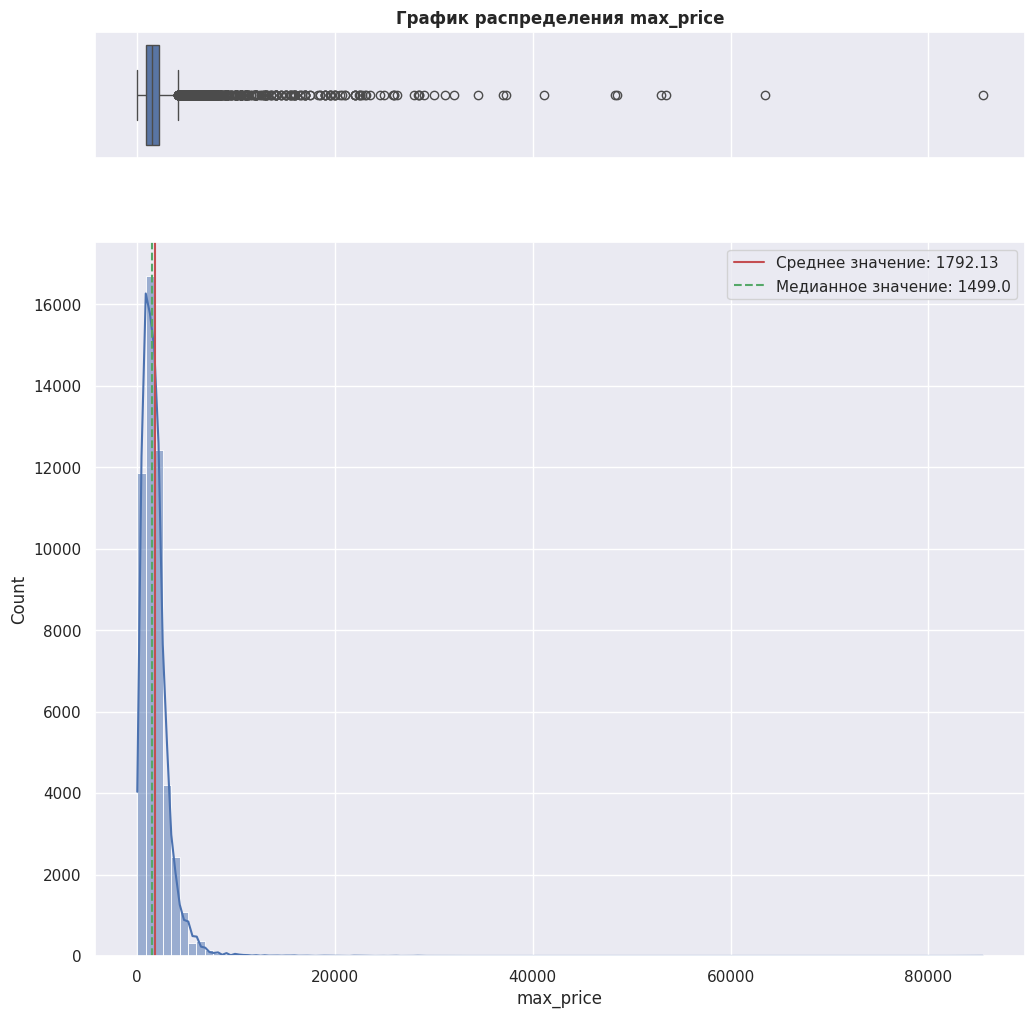

In [28]:
numeric_analysis(df_purchas_price_grouped, 'max_price', 'max_price')

count    49849.000000
mean      1238.219884
std       1384.678770
min          1.000000
25%        399.000000
50%        999.000000
75%       1749.000000
max      53499.000000
Name: min_price, dtype: float64

Верхний ус: 3774.0 
Нижний ус: -1626.0     
Медианное значение: 999.0


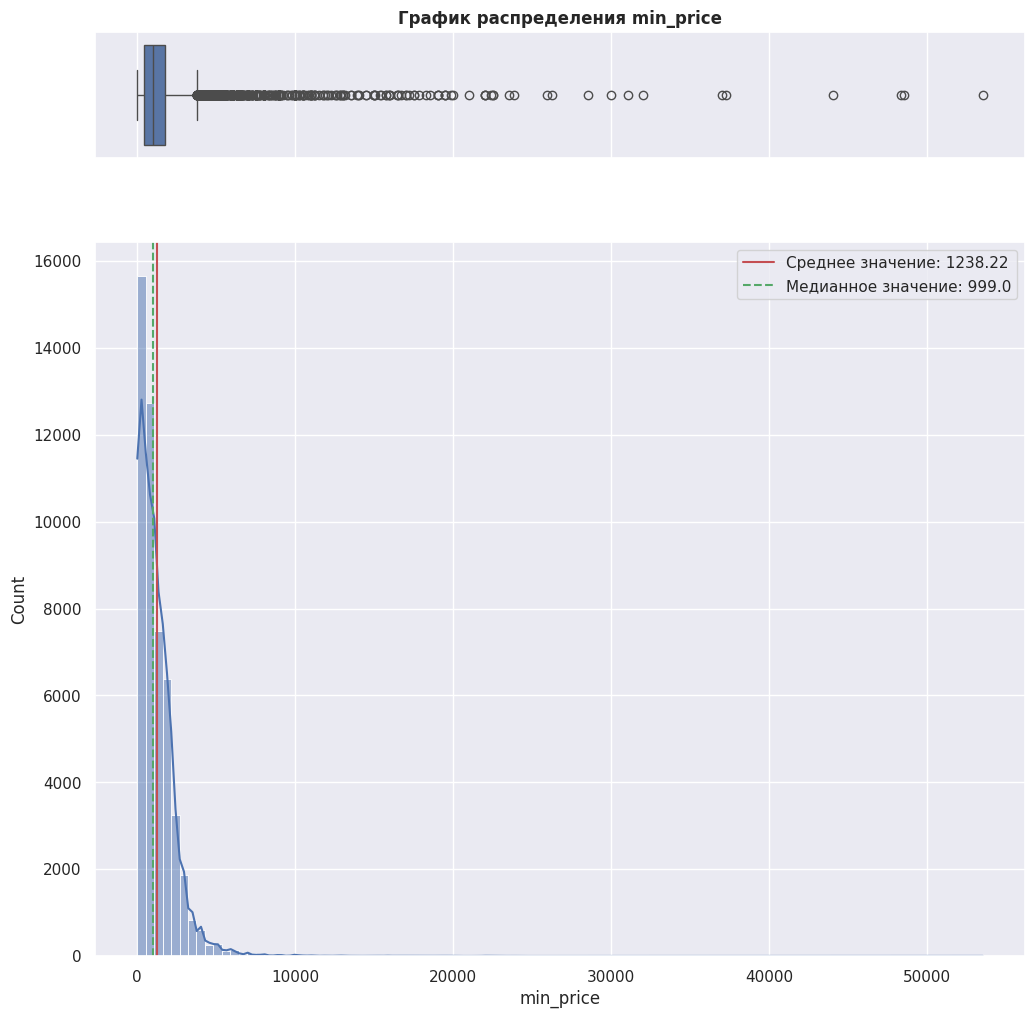

In [29]:
numeric_analysis(df_purchas_price_grouped, 'min_price', 'min_price')

In [30]:
df_purchas_quantity_grouped = df_purchas.groupby('client_id')['quantity'].agg(['min', 'max']).reset_index()
df_purchas_quantity_grouped.rename(columns = {'min': 'min_quantity',
                                           'max': 'max_quantity'}, inplace=True)
df_purchas_quantity_grouped['diff_min_max_quantity'] = df_purchas_quantity_grouped['max_quantity'] - df_purchas_quantity_grouped['min_quantity']


In [31]:
df_purchas_quantity_grouped.head()

,client_id,min_quantity,max_quantity,diff_min_max_quantity
0,1515915625468060902,1,1,0
1,1515915625468061003,1,1,0
2,1515915625468061099,1,1,0
3,1515915625468061100,1,1,0
4,1515915625468061170,1,1,0


In [32]:
df_purchas_pivot_date = pd.pivot_table(df_purchas, values=['quantity' , 'price'], index=['date'], aggfunc="mean").reset_index()
df_purchas_pivot_date.rename(columns={'price': 'mean_price',
                                      'quantity': 'mean_quantity'}, inplace=True)

In [33]:
df_purchas_pivot_date

,date,mean_price,mean_quantity
0,2022-05-16,1729.555556,1.055556
1,2022-05-17,1740.314168,1.012320
2,2022-05-18,1811.222222,1.017921
3,2022-05-19,1352.493976,1.006024
4,2022-05-20,1727.129584,1.020782
...,...,...,...
637,2024-02-12,942.696774,1.006452
638,2024-02-13,1093.839286,1.017857
639,2024-02-14,1445.546841,1.004357
640,2024-02-15,998.275591,1.007874


In [34]:
df_purchas_pivot_date['mean_quantity'].describe()

,mean_quantity
count,642.000000
mean,1.006229
std,0.017424
min,1.000000
25%,1.000000
50%,1.000000
75%,1.006431
max,1.200000


In [35]:
df_purchas.groupby('client_id')['category_ids']

In [36]:
df_purchas_grouped = df_purchas.groupby('client_id')['category_ids'].sum().reset_index()

In [37]:
df_purchas_grouped

,client_id,category_ids
0,1515915625468060902,"['4', '27', '176', '458']['4', '28', '260', '4..."
1,1515915625468061003,"['4', '28', '249', '615']['4', '28', '249', '6..."
2,1515915625468061099,"['4', '28', '290', '424']"
3,1515915625468061100,"['4', '27', '1828', '5717']['4', '27', '1828',..."
4,1515915625468061170,"[][]['2', '18', '258', '441']['2', '18', '258'..."
...,...,...
49844,1515915626010261344,"['2', '18', '212', '726']['2', '18', '212', '7..."
49845,1515915626010266132,"['4', '27', '278', '470']['4', '27', '278', '4..."
49846,1515915626010439406,"['4', '27', '233', '462']['4', '27', '233', '4..."
49847,1515915626010443527,"['2', '18', '274', '446']"


In [38]:
df_purchas['category_ids'] = df_purchas['category_ids'].apply(ast.literal_eval)

df_purchas_grouped = df_purchas.groupby('client_id')['category_ids'].agg(lambda x: list(chain.from_iterable(x))).reset_index()

In [39]:
df_purchas_grouped.head()

,client_id,category_ids
0,1515915625468060902,"[4, 27, 176, 458, 4, 28, 260, 420, 4, 27, 1828..."
1,1515915625468061003,"[4, 28, 249, 615, 4, 28, 249, 615, 4, 28, 249,..."
2,1515915625468061099,"[4, 28, 290, 424]"
3,1515915625468061100,"[4, 27, 1828, 5717, 4, 27, 1828, 5717]"
4,1515915625468061170,"[2, 18, 258, 441, 2, 18, 258, 441, 4, 28, 260,..."


In [40]:
def convert_and_sort(category_list):
    return sorted(filter(lambda y: y is not None, map(lambda x: int(x) if x is not None else None, category_list)))

df_purchas_grouped['category_ids_sorted'] = df_purchas_grouped['category_ids'].apply(convert_and_sort)

In [41]:
df_purchas_grouped['cat_sum'] = df_purchas_grouped['category_ids_sorted'].apply(
    lambda x: sum(int(num) for num in x if num is not None) if isinstance(x, list) else 0
)

In [42]:
df_purchas_grouped.head()

,client_id,category_ids,category_ids_sorted,cat_sum
0,1515915625468060902,"[4, 27, 176, 458, 4, 28, 260, 420, 4, 27, 1828...","[4, 4, 4, 4, 4, 4, 4, 27, 27, 27, 28, 28, 28, ...",7664
1,1515915625468061003,"[4, 28, 249, 615, 4, 28, 249, 615, 4, 28, 249,...","[4, 4, 4, 4, 4, 4, 4, 28, 28, 28, 28, 28, 28, ...",6272
2,1515915625468061099,"[4, 28, 290, 424]","[4, 28, 290, 424]",746
3,1515915625468061100,"[4, 27, 1828, 5717, 4, 27, 1828, 5717]","[4, 4, 27, 27, 1828, 1828, 5717, 5717]",15152
4,1515915625468061170,"[2, 18, 258, 441, 2, 18, 258, 441, 4, 28, 260,...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",12106


In [43]:
df_purchas_grouped_unique = df_purchas.groupby('client_id')['category_ids'].agg(lambda x: list(dict.fromkeys(chain.from_iterable(x)))).reset_index()

In [44]:
df_purchas_grouped_unique.head()

,client_id,category_ids
0,1515915625468060902,"[4, 27, 176, 458, 28, 260, 420, 1828, 1599, 29..."
1,1515915625468061003,"[4, 28, 249, 615]"
2,1515915625468061099,"[4, 28, 290, 424]"
3,1515915625468061100,"[4, 27, 1828, 5717]"
4,1515915625468061170,"[2, 18, 258, 441, 4, 28, 260, 420, 244, 432]"


In [45]:
df_purchas_grouped = df_purchas_grouped_unique.category_ids.apply(pd.Series) \
    .merge(df_purchas_grouped.drop('category_ids_sorted', axis=1), right_index = True, left_index = True) \
    .drop(["category_ids"], axis = 1)

In [46]:
df_purchas_grouped = df_purchas_grouped.drop(df_purchas_grouped.columns[1:87], axis=1)

In [47]:
df_purchas_grouped.head()

,0,client_id,cat_sum
0,4,1515915625468060902,7664
1,4,1515915625468061003,6272
2,4,1515915625468061099,746
3,4,1515915625468061100,15152
4,2,1515915625468061170,12106


In [48]:
df_purchas_grouped.rename(columns={0: 'cat_1',
                                   1: 'cat_2'}, inplace=True)

In [49]:
df_purchas_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cat_1      49551 non-null  object
 1   client_id  49849 non-null  int64 
 2   cat_sum    49849 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [50]:
df_purchas_grouped['cat_1'].value_counts()

,count
cat_1,
4,30269
5562,9644
2,8327
6060,979
5963,332


In [51]:
df_purchas_date_grouped = df_purchas.groupby('client_id')['date'].agg(['min', 'max']).reset_index()
df_purchas_date_grouped

,client_id,min,max
0,1515915625468060902,2022-05-27,2022-05-27
1,1515915625468061003,2023-01-04,2023-01-04
2,1515915625468061099,2022-05-17,2022-05-17
3,1515915625468061100,2024-02-10,2024-02-10
4,1515915625468061170,2023-03-26,2023-06-17
...,...,...,...
49844,1515915626010261344,2024-02-16,2024-02-16
49845,1515915626010266132,2024-02-14,2024-02-14
49846,1515915626010439406,2024-02-16,2024-02-16
49847,1515915626010443527,2024-02-16,2024-02-16


In [52]:
df_purchas_date_grouped['days_between_min_max'] = df_purchas_date_grouped['max'] - df_purchas_date_grouped['min']

In [53]:
df_purchas_date_grouped['days_between_min_max'].describe()

,days_between_min_max
count,49849
mean,21 days 03:10:22.014483741
std,76 days 20:13:23.836373667
min,0 days 00:00:00
25%,0 days 00:00:00
50%,0 days 00:00:00
75%,0 days 00:00:00
max,636 days 00:00:00


In [54]:
df_purchas_date_grouped

,client_id,min,max,days_between_min_max
0,1515915625468060902,2022-05-27,2022-05-27,0 days
1,1515915625468061003,2023-01-04,2023-01-04,0 days
2,1515915625468061099,2022-05-17,2022-05-17,0 days
3,1515915625468061100,2024-02-10,2024-02-10,0 days
4,1515915625468061170,2023-03-26,2023-06-17,83 days
...,...,...,...,...
49844,1515915626010261344,2024-02-16,2024-02-16,0 days
49845,1515915626010266132,2024-02-14,2024-02-14,0 days
49846,1515915626010439406,2024-02-16,2024-02-16,0 days
49847,1515915626010443527,2024-02-16,2024-02-16,0 days


In [55]:
df_purchas_c_unique_dates = df_purchas.groupby('client_id')['date'].nunique().reset_index()

In [56]:
df_purchas_c_unique_dates.head()

,client_id,date
0,1515915625468060902,1
1,1515915625468061003,1
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,3


In [57]:
df_purchas_c_unique_dates.rename(columns={'date': 'unique_dates'}, inplace=True)
df_purchas_c_unique_dates.head()

,client_id,unique_dates
0,1515915625468060902,1
1,1515915625468061003,1
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,3


In [58]:
df_to_use = df_purchas_pivot.merge(df_purchas_date_grouped, on='client_id')

In [59]:
df_to_use.merge(df_purchas_c_unique_dates, on='client_id').head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,unique_dates
0,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0 days,1
1,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0 days,1
2,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0 days,1
3,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0 days,1
4,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83 days,3


In [60]:
df_to_use['days_between_min_max'] = df_to_use['max'] - df_to_use['min']

In [61]:
df_to_use.head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max
0,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0 days
1,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0 days
2,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0 days
3,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0 days
4,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83 days


In [62]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [63]:
df_message_filter = df_messages[df_messages['client_id'].isin(df_purchas['client_id'])].reset_index()

In [64]:
df_message_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950921 entries, 0 to 10950920
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   index             int64         
 1   bulk_campaign_id  int64         
 2   client_id         int64         
 3   message_id        object        
 4   event             object        
 5   channel           object        
 6   date              datetime64[ns]
 7   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 668.4+ MB


In [65]:
df_channel = df_message_filter.groupby('client_id')['channel'].unique().reset_index()

In [66]:
df_channel.head()

,client_id,channel
0,1515915625468060902,[email]
1,1515915625468061003,[email]
2,1515915625468061099,"[email, mobile_push]"
3,1515915625468061100,[mobile_push]
4,1515915625468061170,"[email, mobile_push]"


In [67]:
df_event = df_message_filter.groupby('client_id')['event'].agg(list).reset_index()

In [68]:
df_event.head()

,client_id,event
0,1515915625468060902,"[send, send, send, send, open, click, click, p..."
1,1515915625468061003,"[send, send, send, send, send, send, send, sen..."
2,1515915625468061099,"[send, send, send, send, send, send, open, sen..."
3,1515915625468061100,"[send, send, send, send, send, send, send, sen..."
4,1515915625468061170,"[send, send, open, send, open, send, open, cli..."


In [69]:
def_mes = df_message_filter.groupby('client_id')['message_id'].unique().reset_index()

Сильный дисбаланс в целевом признаке.

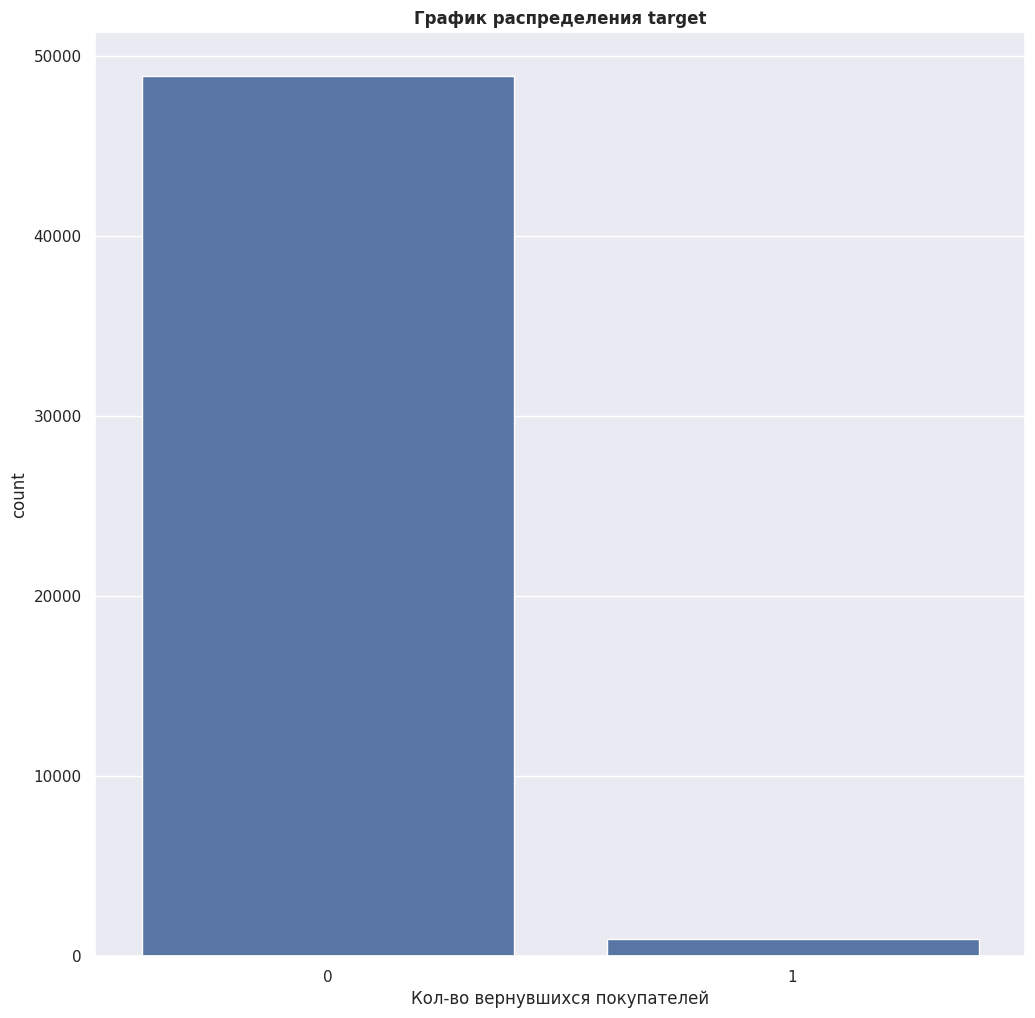

,count
target,
0,48888
1,961


In [70]:
cat_vis(df_target, 'target')

In [71]:
961/48888

0.019657175585010636

##Объединение данных

In [72]:
df_to_use = pd.merge(df_to_use, df_channel, on='client_id', how='outer')


In [73]:
df_to_use = pd.merge(df_to_use, df_event, on='client_id', how='outer')
df_to_use = pd.merge(df_to_use, def_mes, on='client_id', how='outer')

In [74]:
df_to_use = pd.merge(df_to_use, df_purchas_price_grouped, on='client_id', how='outer')

In [75]:
df_to_use = pd.merge(df_to_use, df_purchas_grouped, on='client_id')

In [76]:
df_to_use = pd.merge(df_to_use, df_purchas_quantity_grouped, on='client_id')

In [77]:
df_to_use.head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,channel,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity
0,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0 days,[email],"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0
1,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0 days,[email],"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0
2,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0 days,"[email, mobile_push]","[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0
3,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0 days,[mobile_push],"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0
4,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83 days,"[email, mobile_push]","[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0


In [78]:
type(df_to_use['event'][0])

list

In [79]:
df_to_use['channel'] = df_to_use['channel'].apply(lambda x: x if isinstance(x, np.ndarray) else [])
df_to_use['event'] = df_to_use['event'].apply(lambda x: x if isinstance(x, list) else [])
df_to_use['event_unique'] = df_to_use['event'].apply(lambda x: np.unique(x) if isinstance(x, list) else [])
df_to_use['message_id'] = df_to_use['message_id'].apply(lambda x: x if isinstance(x, np.ndarray) else [])

In [80]:
df_to_use.head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,channel,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,event_unique
0,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0 days,[email],"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0,"[click, open, purchase, send, unsubscribe]"
1,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0 days,[email],"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0,"[click, open, purchase, send]"
2,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0 days,"[email, mobile_push]","[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0,"[click, hard_bounce, open, send]"
3,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0 days,[mobile_push],"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0,"[click, hard_bounce, open, purchase, send, sof..."
4,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83 days,"[email, mobile_push]","[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0,"[click, open, purchase, send]"


In [81]:
def count_size(df, col):
  df[col+'_size'] = df[col].apply(len)
  return df

In [82]:
df_to_use = count_size(df_to_use, 'channel')
df_to_use = count_size(df_to_use, 'event')
df_to_use = count_size(df_to_use, 'message_id')
df_to_use = count_size(df_to_use, 'event_unique')

In [83]:
df_to_use = df_to_use.merge(df_purchas_c_unique_dates, on='client_id')

In [84]:
df_to_use.head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,channel,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,event_unique,channel_size,event_size,message_id_size,event_unique_size,unique_dates
0,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0 days,[email],"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0,"[click, open, purchase, send, unsubscribe]",1,177,127,5,1
1,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0 days,[email],"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0,"[click, open, purchase, send]",1,166,154,4,1
2,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0 days,"[email, mobile_push]","[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0,"[click, hard_bounce, open, send]",2,276,215,4,1
3,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0 days,[mobile_push],"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0,"[click, hard_bounce, open, purchase, send, sof...",1,434,268,6,1
4,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83 days,"[email, mobile_push]","[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0,"[click, open, purchase, send]",2,293,243,4,3


In [85]:
df_message_filter['msg_year'] = df_message_filter.date.dt.year

In [86]:
df_message_filter['msg_month'] = df_message_filter.date.dt.month

In [87]:
df_message_filter['msg_day_of_week'] = df_message_filter.date.dt.day_of_week

In [88]:
df_message_filter.head()

,index,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,msg_year,msg_month,msg_day_of_week
0,0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,2022,5,3
1,1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,2022,5,3
2,2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,2022,5,3
3,3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,2022,5,3
4,4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,2022,5,3


In [89]:
df_min_max_date = df_message_filter.groupby('client_id')['date'].agg(['min', 'max']).reset_index()

In [90]:
df_min_max_date['days_between_min_max_msg'] = df_min_max_date['max'] - df_min_max_date['min']

In [91]:
df_min_max_date['min_year_msg'] = df_min_max_date['min'].dt.year
df_min_max_date['max_year_msg'] = df_min_max_date['max'].dt.year
df_min_max_date['min_month_msg'] = df_min_max_date['min'].dt.month
df_min_max_date['max_month_msg'] = df_min_max_date['max'].dt.month
df_min_max_date['min_day_of_week_msg'] = df_min_max_date['min'].dt.day_of_week
df_min_max_date['max_day_of_week_msg'] = df_min_max_date['max'].dt.day_of_week
df_min_max_date['min_day_of_year_msg'] = df_min_max_date['min'].dt.day_of_year
df_min_max_date['max_day_of_year_msg'] = df_min_max_date['max'].dt.day_of_year

In [92]:
df_min_max_date.head()

,client_id,min,max,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg
0,1515915625468060902,2022-05-19,2024-01-19,610 days,2022,2024,5,1,3,4,139,19
1,1515915625468061003,2022-05-20,2024-02-13,634 days,2022,2024,5,2,4,1,140,44
2,1515915625468061099,2022-05-19,2024-02-13,635 days,2022,2024,5,2,3,1,139,44
3,1515915625468061100,2022-05-19,2024-02-15,637 days,2022,2024,5,2,3,3,139,46
4,1515915625468061170,2022-05-25,2024-02-15,631 days,2022,2024,5,2,2,3,145,46


In [93]:
df_to_use = pd.merge(df_to_use, df_min_max_date.drop(['min', 'max'], axis=1), on='client_id', how='outer')

In [94]:
df_to_use.head()

,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,channel,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,event_unique,channel_size,event_size,message_id_size,event_unique_size,unique_dates,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg
0,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0 days,[email],"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0,"[click, open, purchase, send, unsubscribe]",1,177,127,5,1,610 days,2022.0,2024.0,5.0,1.0,3.0,4.0,139.0,19.0
1,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0 days,[email],"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0,"[click, open, purchase, send]",1,166,154,4,1,634 days,2022.0,2024.0,5.0,2.0,4.0,1.0,140.0,44.0
2,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0 days,"[email, mobile_push]","[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0,"[click, hard_bounce, open, send]",2,276,215,4,1,635 days,2022.0,2024.0,5.0,2.0,3.0,1.0,139.0,44.0
3,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0 days,[mobile_push],"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0,"[click, hard_bounce, open, purchase, send, sof...",1,434,268,6,1,637 days,2022.0,2024.0,5.0,2.0,3.0,3.0,139.0,46.0
4,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83 days,"[email, mobile_push]","[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0,"[click, open, purchase, send]",2,293,243,4,3,631 days,2022.0,2024.0,5.0,2.0,2.0,3.0,145.0,46.0


In [95]:
df_to_use['min_year_purchas'] = df_to_use['min'].dt.year
df_to_use['max_year_purchas'] = df_to_use['max'].dt.year
df_to_use['min_month_purchas'] = df_to_use['min'].dt.month
df_to_use['max_month_purchas'] = df_to_use['max'].dt.month
df_to_use['min_day_of_week_purchas'] = df_to_use['min'].dt.day_of_week
df_to_use['max_day_of_week_purchas'] = df_to_use['max'].dt.day_of_week
df_to_use['min_day_of_year_purchas'] = df_to_use['min'].dt.day_of_year
df_to_use['max_day_of_year_purchas'] = df_to_use['max'].dt.day_of_year

In [96]:
df_to_use = pd.merge(df_to_use, df_target, on='client_id')

In [97]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   client_id                 49849 non-null  int64          
 1   sum_price                 49849 non-null  float64        
 2   sum_quantity              49849 non-null  int64          
 3   mean_price                49849 non-null  float64        
 4   total_price               49849 non-null  float64        
 5   min                       49849 non-null  datetime64[ns] 
 6   max                       49849 non-null  datetime64[ns] 
 7   days_between_min_max      49849 non-null  timedelta64[ns]
 8   channel                   49849 non-null  object         
 9   event                     49849 non-null  object         
 10  message_id                49849 non-null  object         
 11  min_price                 49849 non-null  float64        
 12  max_

In [98]:
df_to_use['days_between_min_max'] = df_to_use['days_between_min_max'].dt.days
df_to_use['days_between_min_max_msg'] = df_to_use['days_between_min_max_msg'].dt.days

In [99]:
df_to_use = df_to_use.channel.apply(pd.Series) \
    .merge(df_to_use, right_index = True, left_index = True) \
    .drop(["channel"], axis = 1)

In [100]:
df_to_use.head()

,0,1,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,event_unique,channel_size,event_size,message_id_size,event_unique_size,unique_dates,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg,min_year_purchas,max_year_purchas,min_month_purchas,max_month_purchas,min_day_of_week_purchas,max_day_of_week_purchas,min_day_of_year_purchas,max_day_of_year_purchas,target
0,email,NaN,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0,"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0,"[click, open, purchase, send, unsubscribe]",1,177,127,5,1,610.0,2022.0,2024.0,5.0,1.0,3.0,4.0,139.0,19.0,2022,2022,5,5,4,4,147,147,0
1,email,NaN,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0,"[click, open, purchase, send]",1,166,154,4,1,634.0,2022.0,2024.0,5.0,2.0,4.0,1.0,140.0,44.0,2023,2023,1,1,2,2,4,4,1
2,email,mobile_push,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0,"[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0,"[click, hard_bounce, open, send]",2,276,215,4,1,635.0,2022.0,2024.0,5.0,2.0,3.0,1.0,139.0,44.0,2022,2022,5,5,1,1,137,137,0
3,mobile_push,NaN,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0,"[click, hard_bounce, open, purchase, send, sof...",1,434,268,6,1,637.0,2022.0,2024.0,5.0,2.0,3.0,3.0,139.0,46.0,2024,2024,2,2,5,5,41,41,0
4,email,mobile_push,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83,"[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0,"[click, open, purchase, send]",2,293,243,4,3,631.0,2022.0,2024.0,5.0,2.0,2.0,3.0,145.0,46.0,2023,2023,3,6,6,5,85,168,0


In [101]:
df_to_use.rename(columns = {0: 'channel_1',
                            1: 'channel_2'}, inplace=True)

In [102]:
df_to_use.head()

,channel_1,channel_2,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,event_unique,channel_size,event_size,message_id_size,event_unique_size,unique_dates,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg,min_year_purchas,max_year_purchas,min_month_purchas,max_month_purchas,min_day_of_week_purchas,max_day_of_week_purchas,min_day_of_year_purchas,max_day_of_year_purchas,target
0,email,NaN,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0,"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0,"[click, open, purchase, send, unsubscribe]",1,177,127,5,1,610.0,2022.0,2024.0,5.0,1.0,3.0,4.0,139.0,19.0,2022,2022,5,5,4,4,147,147,0
1,email,NaN,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0,"[click, open, purchase, send]",1,166,154,4,1,634.0,2022.0,2024.0,5.0,2.0,4.0,1.0,140.0,44.0,2023,2023,1,1,2,2,4,4,1
2,email,mobile_push,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0,"[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0,"[click, hard_bounce, open, send]",2,276,215,4,1,635.0,2022.0,2024.0,5.0,2.0,3.0,1.0,139.0,44.0,2022,2022,5,5,1,1,137,137,0
3,mobile_push,NaN,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0,"[click, hard_bounce, open, purchase, send, sof...",1,434,268,6,1,637.0,2022.0,2024.0,5.0,2.0,3.0,3.0,139.0,46.0,2024,2024,2,2,5,5,41,41,0
4,email,mobile_push,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83,"[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0,"[click, open, purchase, send]",2,293,243,4,3,631.0,2022.0,2024.0,5.0,2.0,2.0,3.0,145.0,46.0,2023,2023,3,6,6,5,85,168,0


In [103]:
df_to_use = df_to_use.event_unique.apply(pd.Series) \
    .merge(df_to_use, right_index = True, left_index = True) \
    .drop(["event_unique"], axis = 1)

In [104]:
df_to_use.head()

,0,1,2,3,4,5,6,7,channel_1,channel_2,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,channel_size,event_size,message_id_size,event_unique_size,unique_dates,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg,min_year_purchas,max_year_purchas,min_month_purchas,max_month_purchas,min_day_of_week_purchas,max_day_of_week_purchas,min_day_of_year_purchas,max_day_of_year_purchas,target
0,click,open,purchase,send,unsubscribe,NaN,NaN,NaN,email,NaN,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0,"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0,1,177,127,5,1,610.0,2022.0,2024.0,5.0,1.0,3.0,4.0,139.0,19.0,2022,2022,5,5,4,4,147,147,0
1,click,open,purchase,send,NaN,NaN,NaN,NaN,email,NaN,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0,1,166,154,4,1,634.0,2022.0,2024.0,5.0,2.0,4.0,1.0,140.0,44.0,2023,2023,1,1,2,2,4,4,1
2,click,hard_bounce,open,send,NaN,NaN,NaN,NaN,email,mobile_push,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0,"[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0,2,276,215,4,1,635.0,2022.0,2024.0,5.0,2.0,3.0,1.0,139.0,44.0,2022,2022,5,5,1,1,137,137,0
3,click,hard_bounce,open,purchase,send,soft_bounce,NaN,NaN,mobile_push,NaN,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0,1,434,268,6,1,637.0,2022.0,2024.0,5.0,2.0,3.0,3.0,139.0,46.0,2024,2024,2,2,5,5,41,41,0
4,click,open,purchase,send,NaN,NaN,NaN,NaN,email,mobile_push,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83,"[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0,2,293,243,4,3,631.0,2022.0,2024.0,5.0,2.0,2.0,3.0,145.0,46.0,2023,2023,3,6,6,5,85,168,0


In [105]:
df_to_use.rename(columns = {0: 'event_1',
                            1: 'event_2',
                            2: 'event_3',
                            3: 'event_4',
                            4: 'event_5',
                            5: 'event_6',
                            6: 'event_7',
                            7: 'event_8'}, inplace=True)

In [106]:
df_to_use.head()

,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,channel_1,channel_2,client_id,sum_price,sum_quantity,mean_price,total_price,min,max,days_between_min_max,event,message_id,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,channel_size,event_size,message_id_size,event_unique_size,unique_dates,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg,min_year_purchas,max_year_purchas,min_month_purchas,max_month_purchas,min_day_of_week_purchas,max_day_of_week_purchas,min_day_of_year_purchas,max_day_of_year_purchas,target
0,click,open,purchase,send,unsubscribe,NaN,NaN,NaN,email,NaN,1515915625468060902,6993.0,7,999.000000,48951.0,2022-05-27,2022-05-27,0,"[send, send, send, send, open, click, click, p...","[1515915625468060902-4463-6285e404c62b9, 15159...",199.0,1999.0,1800.0,4,7664,1,1,0,1,177,127,5,1,610.0,2022.0,2024.0,5.0,1.0,3.0,4.0,139.0,19.0,2022,2022,5,5,4,4,147,147,0
1,click,open,purchase,send,NaN,NaN,NaN,NaN,email,NaN,1515915625468061003,16235.0,7,2319.285714,113645.0,2023-01-04,2023-01-04,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061003-4492-62873cd7dc557, 15159...",1749.0,3499.0,1750.0,4,6272,1,1,0,1,166,154,4,1,634.0,2022.0,2024.0,5.0,2.0,4.0,1.0,140.0,44.0,2023,2023,1,1,2,2,4,4,1
2,click,hard_bounce,open,send,NaN,NaN,NaN,NaN,email,mobile_push,1515915625468061099,299.0,1,299.000000,299.0,2022-05-17,2022-05-17,0,"[send, send, send, send, send, send, open, sen...","[1515915625468061099-4463-6285e40a6474e, 15159...",299.0,299.0,0.0,4,746,1,1,0,2,276,215,4,1,635.0,2022.0,2024.0,5.0,2.0,3.0,1.0,139.0,44.0,2022,2022,5,5,1,1,137,137,0
3,click,hard_bounce,open,purchase,send,soft_bounce,NaN,NaN,mobile_push,NaN,1515915625468061100,2098.0,2,1049.000000,4196.0,2024-02-10,2024-02-10,0,"[send, send, send, send, send, send, send, sen...","[1515915625468061100-4498-628642df5f5a6, 15159...",1049.0,1049.0,0.0,4,15152,1,1,0,1,434,268,6,1,637.0,2022.0,2024.0,5.0,2.0,3.0,3.0,139.0,46.0,2024,2024,2,2,5,5,41,41,0
4,click,open,purchase,send,NaN,NaN,NaN,NaN,email,mobile_push,1515915625468061170,33601.0,19,1768.473684,638419.0,2023-03-26,2023-06-17,83,"[send, send, open, send, open, send, open, cli...","[1515915625468061170-4568-628ddb581ec2a, 15159...",7.0,2699.0,2692.0,2,12106,1,1,0,2,293,243,4,3,631.0,2022.0,2024.0,5.0,2.0,2.0,3.0,145.0,46.0,2023,2023,3,6,6,5,85,168,0


In [107]:
df_to_use.drop(columns=['event', 'message_id', 'min', 'max'], axis=1, inplace=True)

In [108]:
df_to_use.head()

,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,channel_1,channel_2,client_id,sum_price,sum_quantity,mean_price,total_price,days_between_min_max,min_price,max_price,diff_min_max_price,cat_1,cat_sum,min_quantity,max_quantity,diff_min_max_quantity,channel_size,event_size,message_id_size,event_unique_size,unique_dates,days_between_min_max_msg,min_year_msg,max_year_msg,min_month_msg,max_month_msg,min_day_of_week_msg,max_day_of_week_msg,min_day_of_year_msg,max_day_of_year_msg,min_year_purchas,max_year_purchas,min_month_purchas,max_month_purchas,min_day_of_week_purchas,max_day_of_week_purchas,min_day_of_year_purchas,max_day_of_year_purchas,target
0,click,open,purchase,send,unsubscribe,NaN,NaN,NaN,email,NaN,1515915625468060902,6993.0,7,999.000000,48951.0,0,199.0,1999.0,1800.0,4,7664,1,1,0,1,177,127,5,1,610.0,2022.0,2024.0,5.0,1.0,3.0,4.0,139.0,19.0,2022,2022,5,5,4,4,147,147,0
1,click,open,purchase,send,NaN,NaN,NaN,NaN,email,NaN,1515915625468061003,16235.0,7,2319.285714,113645.0,0,1749.0,3499.0,1750.0,4,6272,1,1,0,1,166,154,4,1,634.0,2022.0,2024.0,5.0,2.0,4.0,1.0,140.0,44.0,2023,2023,1,1,2,2,4,4,1
2,click,hard_bounce,open,send,NaN,NaN,NaN,NaN,email,mobile_push,1515915625468061099,299.0,1,299.000000,299.0,0,299.0,299.0,0.0,4,746,1,1,0,2,276,215,4,1,635.0,2022.0,2024.0,5.0,2.0,3.0,1.0,139.0,44.0,2022,2022,5,5,1,1,137,137,0
3,click,hard_bounce,open,purchase,send,soft_bounce,NaN,NaN,mobile_push,NaN,1515915625468061100,2098.0,2,1049.000000,4196.0,0,1049.0,1049.0,0.0,4,15152,1,1,0,1,434,268,6,1,637.0,2022.0,2024.0,5.0,2.0,3.0,3.0,139.0,46.0,2024,2024,2,2,5,5,41,41,0
4,click,open,purchase,send,NaN,NaN,NaN,NaN,email,mobile_push,1515915625468061170,33601.0,19,1768.473684,638419.0,83,7.0,2699.0,2692.0,2,12106,1,1,0,2,293,243,4,3,631.0,2022.0,2024.0,5.0,2.0,2.0,3.0,145.0,46.0,2023,2023,3,6,6,5,85,168,0


In [109]:
cat_cols = df_to_use.select_dtypes('object').columns.tolist()
for col in cat_cols:
  df_to_use[col].fillna('uknown', inplace=True)

##Корреляционный анализ

In [110]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   event_1                   49849 non-null  object 
 1   event_2                   49849 non-null  object 
 2   event_3                   49849 non-null  object 
 3   event_4                   49849 non-null  object 
 4   event_5                   49849 non-null  object 
 5   event_6                   49849 non-null  object 
 6   event_7                   49849 non-null  object 
 7   event_8                   49849 non-null  object 
 8   channel_1                 49849 non-null  object 
 9   channel_2                 49849 non-null  object 
 10  client_id                 49849 non-null  int64  
 11  sum_price                 49849 non-null  float64
 12  sum_quantity              49849 non-null  int64  
 13  mean_price                49849 non-null  float64
 14  total_

In [111]:
num_cols = df_to_use.drop('client_id', axis=1).select_dtypes(include='number').columns.tolist()
num_cols

['sum_price',
 'sum_quantity',
 'mean_price',
 'total_price',
 'days_between_min_max',
 'min_price',
 'max_price',
 'diff_min_max_price',
 'cat_sum',
 'min_quantity',
 'max_quantity',
 'diff_min_max_quantity',
 'channel_size',
 'event_size',
 'message_id_size',
 'event_unique_size',
 'unique_dates',
 'days_between_min_max_msg',
 'min_year_msg',
 'max_year_msg',
 'min_month_msg',
 'max_month_msg',
 'min_day_of_week_msg',
 'max_day_of_week_msg',
 'min_day_of_year_msg',
 'max_day_of_year_msg',
 'min_year_purchas',
 'max_year_purchas',
 'min_month_purchas',
 'max_month_purchas',
 'min_day_of_week_purchas',
 'max_day_of_week_purchas',
 'min_day_of_year_purchas',
 'max_day_of_year_purchas',
 'target']

In [112]:
corr = df_to_use.drop(columns='client_id').phik_matrix(interval_cols=num_cols)

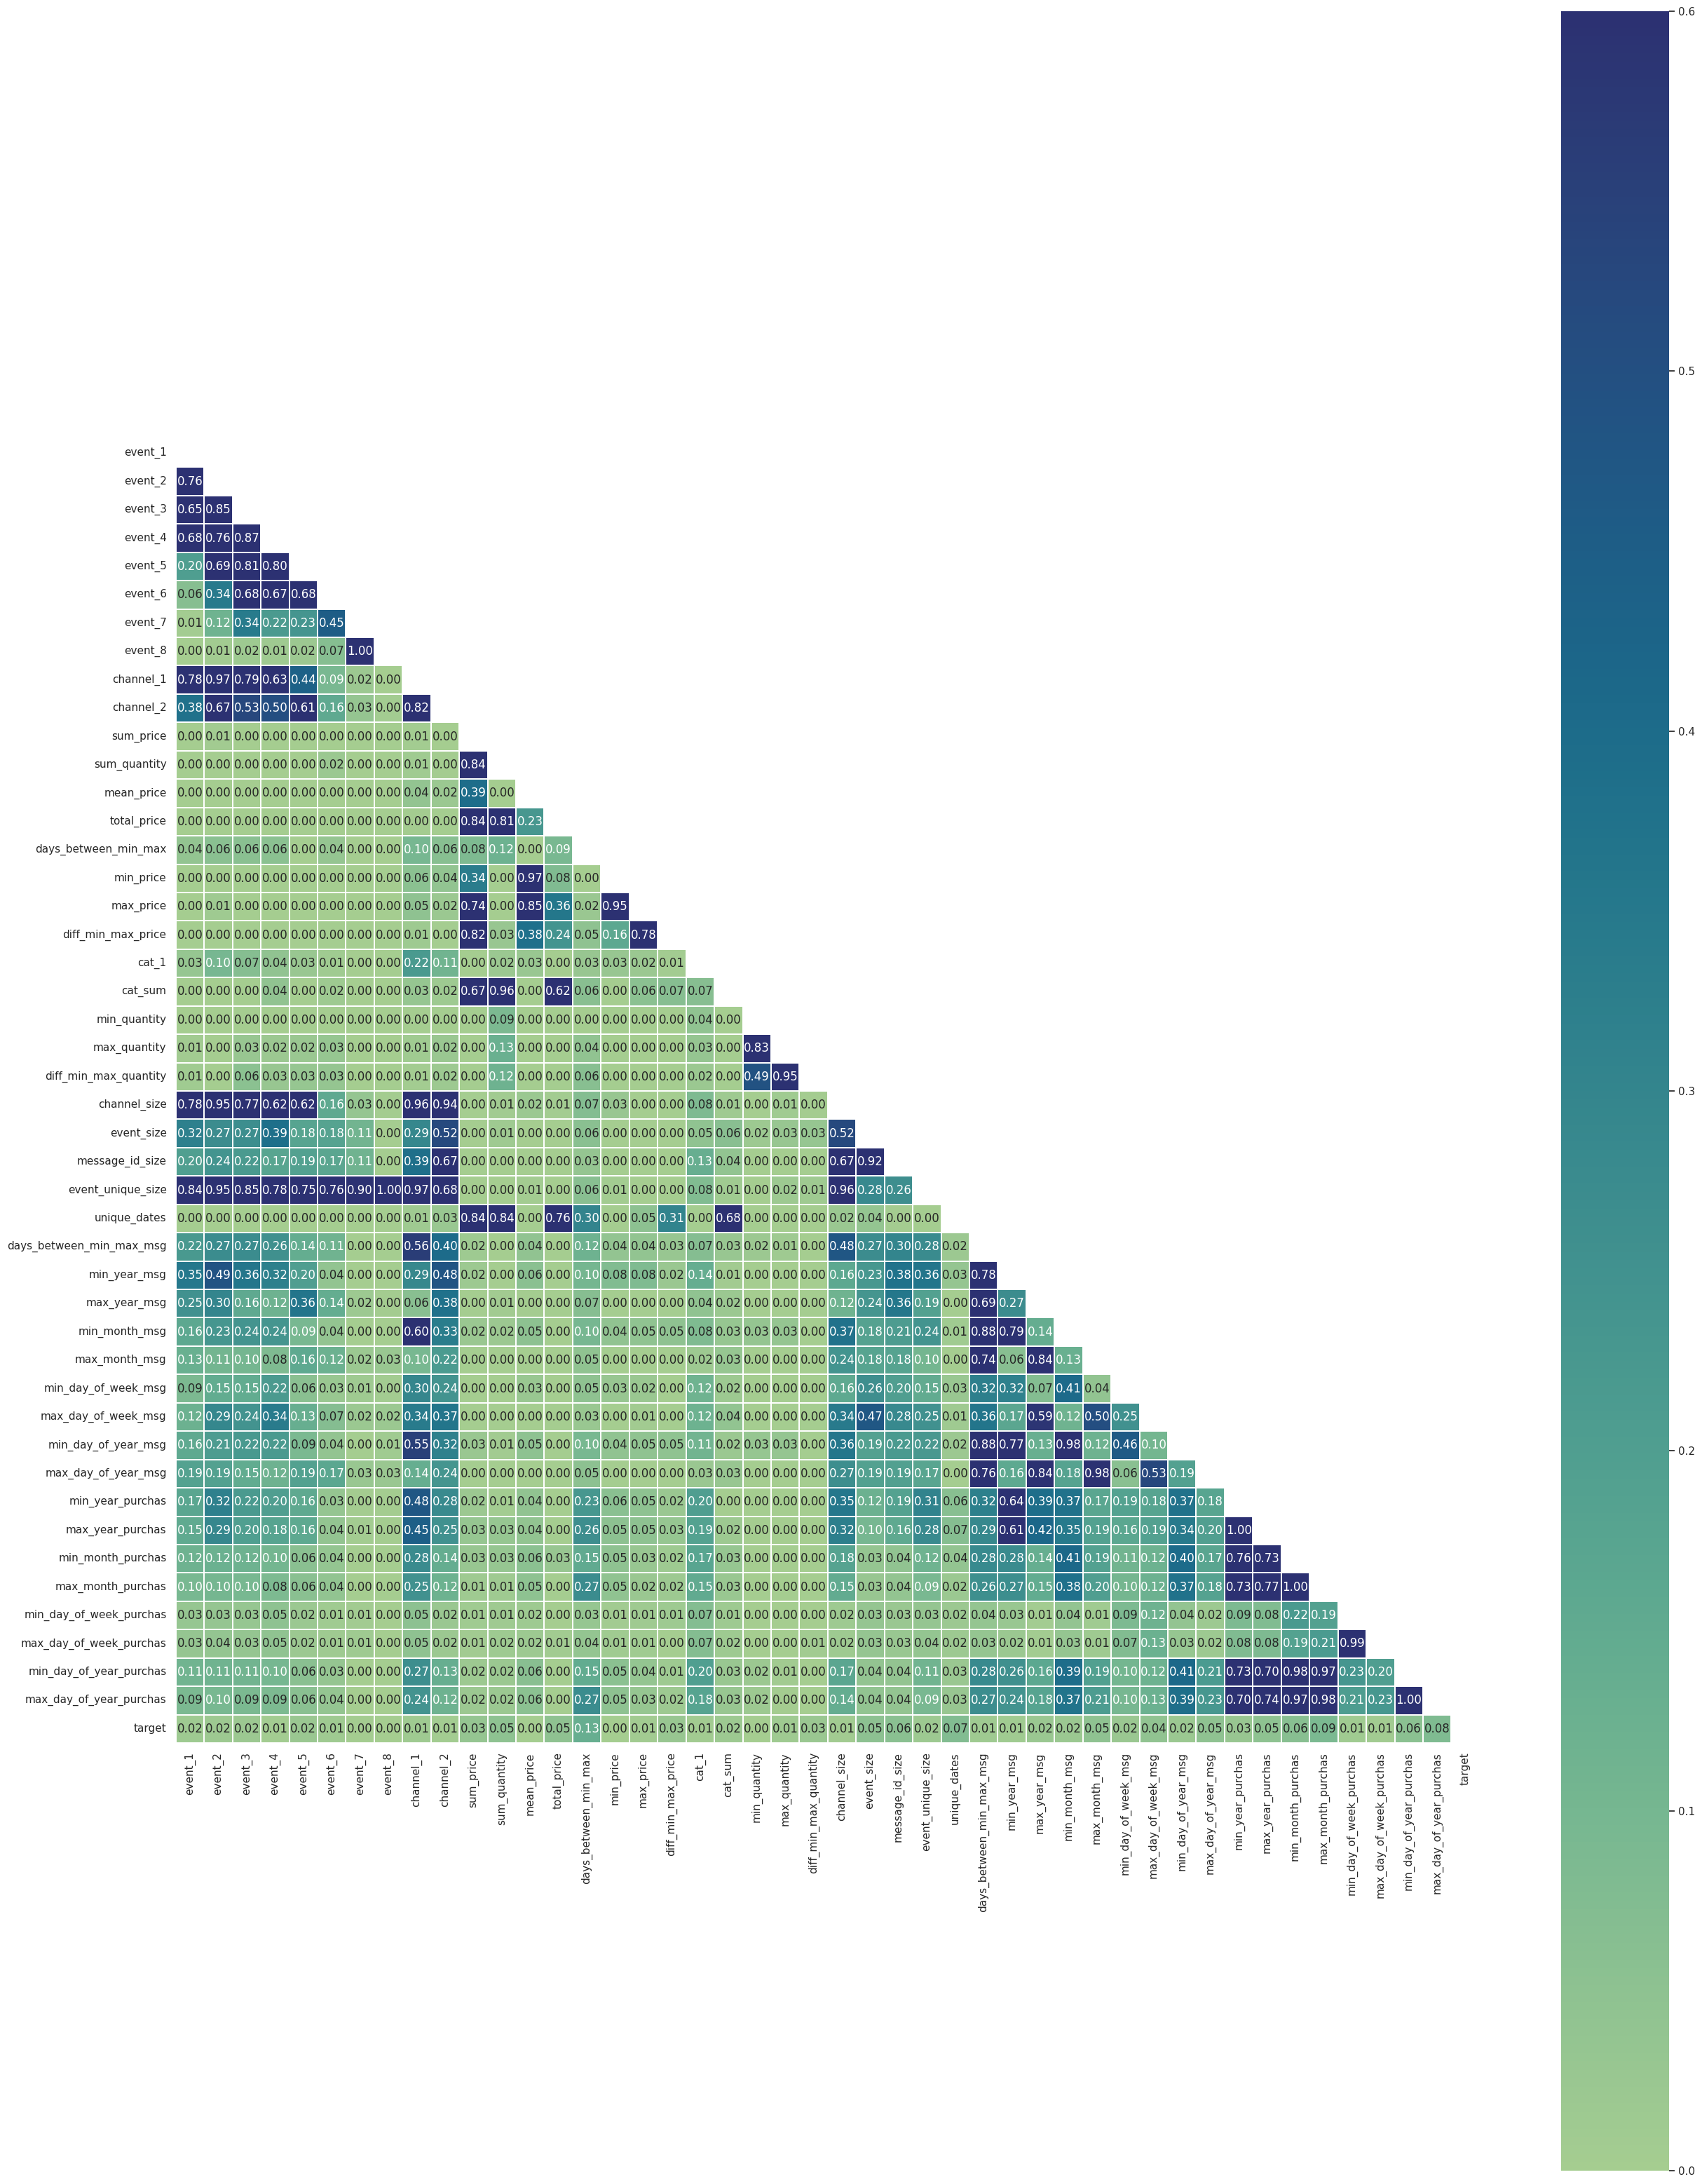

In [113]:
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_theme(style="white")
plt.figure(figsize=(30, 40))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr, mask=mask,
            square=True,
            linewidths=.3,
            vmax=0.6,
            annot=True,
            cmap=cmap,
            fmt='.2f')

plt.show()

##Обучение модели и предсказания



In [114]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [115]:
df_to_use = optimize_memory_usage(df_to_use)

Размер использования памяти: до 16.35 Mb - после  8.89 Mb (45.6%)


In [116]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   event_1                   49849 non-null  object 
 1   event_2                   49849 non-null  object 
 2   event_3                   49849 non-null  object 
 3   event_4                   49849 non-null  object 
 4   event_5                   49849 non-null  object 
 5   event_6                   49849 non-null  object 
 6   event_7                   49849 non-null  object 
 7   event_8                   49849 non-null  object 
 8   channel_1                 49849 non-null  object 
 9   channel_2                 49849 non-null  object 
 10  client_id                 49849 non-null  int64  
 11  sum_price                 49849 non-null  float32
 12  sum_quantity              49849 non-null  int16  
 13  mean_price                49849 non-null  float32
 14  total_

In [117]:
cols_to_drop = ['client_id', 'target']

In [118]:
X = df_to_use.drop(columns=cols_to_drop, axis=1)
Y = df_to_use.target

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=Y
)

In [120]:
def convert_to_category(x):
    for i in x.columns:
        column_type = x[i].dtypes
        if column_type == 'object':
            x[i] = x[i].astype('category')

    return x

In [121]:
X_train = convert_to_category(X_train)
X_test = convert_to_category(X_test)

In [122]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37386 entries, 31283 to 7811
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   event_1                   37386 non-null  category
 1   event_2                   37386 non-null  category
 2   event_3                   37386 non-null  category
 3   event_4                   37386 non-null  category
 4   event_5                   37386 non-null  category
 5   event_6                   37386 non-null  category
 6   event_7                   37386 non-null  category
 7   event_8                   37386 non-null  category
 8   channel_1                 37386 non-null  category
 9   channel_2                 37386 non-null  category
 10  sum_price                 37386 non-null  float32 
 11  sum_quantity              37386 non-null  int16   
 12  mean_price                37386 non-null  float32 
 13  total_price               37386 non-null  float3

In [123]:
pipe = Pipeline(
    [
        ('models', LGBMClassifier(learning_rate=0.05, n_estimators=250, random_state=RANDOM_STATE, n_jobs=-1, is_unbalance=True, objective='binary', verbose=-1))
    ]
)

In [124]:
param_grid = [
    {
        'models__n_estimators': range(100, 500, 50),
        'models__learning_rate': [0.05, 0.1, 0.3, 0.5, 0.6],
        'models__num_leaves': range(10, 60, 10),
        'models__min_child_samples': range(20, 500, 20),
        'models__max_depth': range(3, 15)
    },
     {
        'models': [CatBoostClassifier(random_seed=RANDOM_STATE, nan_mode='Min', verbose=-1)],
        'models__iterations': range(100, 1000, 100),
        'models__learning_rate': [0.05, 0.1, 0.3, 0.5],
        'models__depth': range(3, 15),
        'models__border_count': [32, 50, 100],
        'models__random_strength': [1, 2, 3]
    }
]

In [125]:
scoring = {'f1_score': 'f1',
           'roc_auc_score': 'roc_auc'}

rndcv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
    refit = 'roc_auc_score'
)

In [126]:
rndcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              LGBMClassifier(is_unbalance=True,
                                                             learning_rate=0.05,
                                                             n_estimators=250,
                                                             n_jobs=-1,
                                                             objective='binary',
                                                             random_state=15,
                                                             verbose=-1))]),
                   n_jobs=-1,
                   param_distributions=[{'models__learning_rate': [0.05, 0.1,
                                                                   0.3, 0.5,
                                                                   0.6],
                                         'models__max_depth': range(3, 15),
                                         'models__min_child_samples': range(20, 500, 20),
                                         'mode...
                                         'models__num_leaves': range(10, 60, 10)},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x7d0b0e122f50>],
                                         'models__border_count': [32, 50, 100],
                                         'models__depth': range(3, 15),
                                         'models__iterations': range(100, 1000, 100),
                                         'models__learning_rate': [0.05, 0.1,
                                                                   0.3, 0.5],
                                         'models__random_strength': [1, 2, 3]}],
                   random_state=15, refit='roc_auc_score',
                   scoring={'f1_score': 'f1', 'roc_auc_score': 'roc_auc'})

In [127]:
pd.DataFrame(rndcv.cv_results_).sort_values(by='rank_test_roc_auc_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__num_leaves,param_models__n_estimators,param_models__min_child_samples,param_models__max_depth,param_models__learning_rate,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_roc_auc_score,split1_test_roc_auc_score,split2_test_roc_auc_score,split3_test_roc_auc_score,split4_test_roc_auc_score,mean_test_roc_auc_score,std_test_roc_auc_score,rank_test_roc_auc_score
2,46.778377,6.684053,0.757712,0.241476,20,350,360,9,0.05,"{'models__num_leaves': 20, 'models__n_estimato...",0.108053,0.084592,0.126687,0.086114,0.089172,0.098924,0.016240,3,0.723924,0.689632,0.743737,0.680595,0.689347,0.705447,0.024226,1
0,47.433491,13.310785,0.871983,0.270384,50,300,180,9,0.05,"{'models__num_leaves': 50, 'models__n_estimato...",0.129693,0.098074,0.151142,0.097561,0.083045,0.111903,0.024843,1,0.711224,0.693688,0.708233,0.658548,0.656983,0.685735,0.023601,2
8,47.303274,13.076172,0.698851,0.200020,50,350,100,8,0.05,"{'models__num_leaves': 50, 'models__n_estimato...",0.131687,0.083916,0.157895,0.086560,0.067720,0.105556,0.033713,2,0.711913,0.674789,0.692711,0.649612,0.662783,0.678362,0.021971,3
7,19.607166,1.597798,0.205824,0.010343,20,200,180,4,0.30,"{'models__num_leaves': 20, 'models__n_estimato...",0.060072,0.045718,0.087197,0.058182,0.060360,0.062306,0.013569,4,0.588281,0.532459,0.599015,0.569613,0.572187,0.572311,0.022643,4
1,27.331794,10.141476,0.248152,0.070702,20,400,80,11,0.50,"{'models__num_leaves': 20, 'models__n_estimato...",0.044673,0.048658,0.056401,0.043465,0.048481,0.048336,0.004524,6,0.543741,0.563701,0.579887,0.539308,0.564026,0.558132,0.014836,5


In [128]:
best_model = rndcv.best_estimator_

y_pred = best_model.predict(X_test)

In [129]:
f_importance = best_model.named_steps['models'].feature_importances_
f_names = rndcv.best_estimator_.feature_names_in_

feature_importance_df = pd.DataFrame({
    'Feature': f_names,
    'Importance': f_importance
}).sort_values(by='Importance', ascending=False)

In [130]:
feature_importance_df

,Feature,Importance
19,cat_sum,611
24,event_size,510
25,message_id_size,502
44,max_day_of_year_purchas,446
43,min_day_of_year_purchas,376
10,sum_price,362
15,min_price,356
16,max_price,334
12,mean_price,315
13,total_price,315


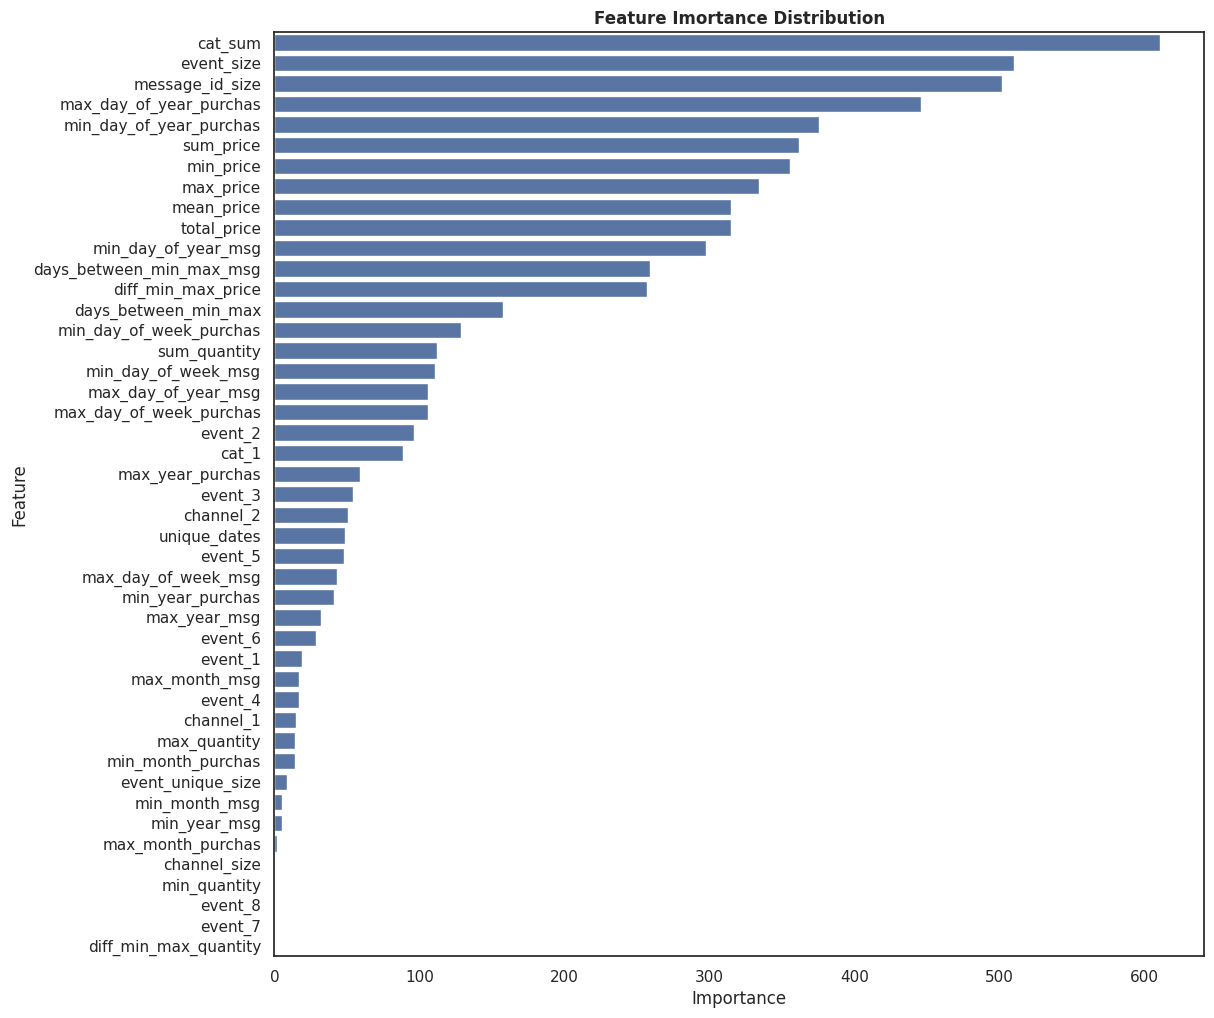

In [131]:
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df)
plt.title('Feature Imortance Distribution', weight='bold')
plt.show()

In [132]:
pd.DataFrame(feature_importance_df[feature_importance_df['Importance'] < 20].values)[0].tolist()

['event_1',
 'max_month_msg',
 'event_4',
 'channel_1',
 'max_quantity',
 'min_month_purchas',
 'event_unique_size',
 'min_month_msg',
 'min_year_msg',
 'max_month_purchas',
 'channel_size',
 'min_quantity',
 'event_8',
 'event_7',
 'diff_min_max_quantity']

In [133]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))
print('f1: ',round(f1, 3))

recall:  0.325
precision:  0.046
f1:  0.081


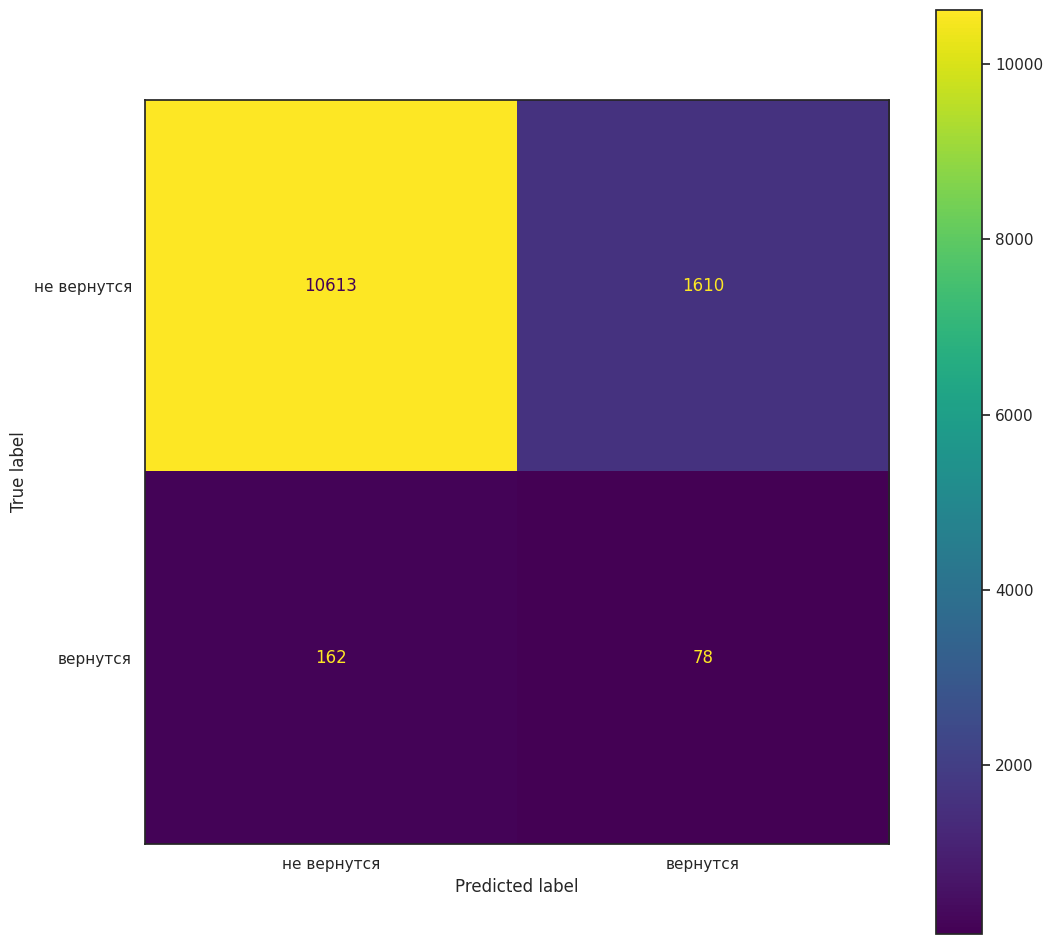

In [134]:
sns.set_theme(style="white")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['не вернутся', 'вернутся'])
disp.plot()

plt.show()

In [135]:
y_proba = rndcv.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
data.head(20)

,y_valid,y_proba
2569,0,0.979279
6133,0,0.971292
389,0,0.956465
10734,0,0.953140
9265,0,0.951587
11463,0,0.946418
5820,0,0.946347
3292,0,0.943299
7503,0,0.941977
387,0,0.936965


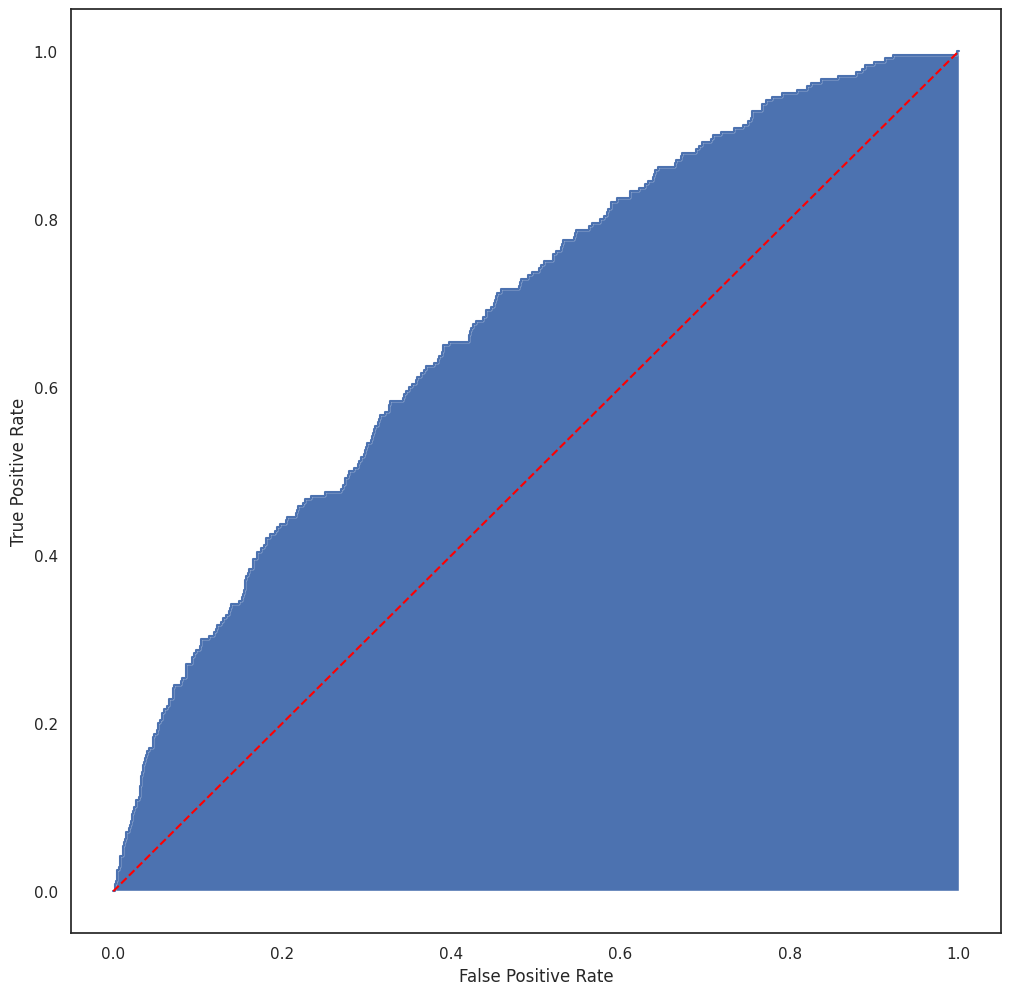

AUC: 0.682


In [136]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

auc = roc_auc_score(y_test, y_proba)
plt.fill_between(fpr, tpr)
plt.show()
print("AUC: %.3f" % auc)

In [137]:
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=15, strategy='stratified')

In [138]:
dummy_y = dummy_model.predict(X_test)
dummy_pred_y = dummy_model.predict_proba(X_test)[:, 1]

In [139]:
f1_dummy = f1_score(y_test, dummy_y)
roc_auc_dummy = roc_auc_score(y_test, dummy_pred_y)
pd.DataFrame(data=[f1_dummy, roc_auc_dummy], index=['f1_dummy', 'roc_auc_dummy'], columns=['score'])

,score
f1_dummy,0.025105
roc_auc_dummy,0.503010


## Вывод

Модель на основании существующих данных определили 78 потенциальных клиентов, которые вернутся в ближайшее время. При этом 1610 клиентов, которые не вернутся и 162 клиента, которые могут вернутся она определила неверно.

Для более точной оценки выгоды для бизнеса не хватает данных по затратам на маркетинг.

При этом бизнесу стоит обратить на следующие признаки:
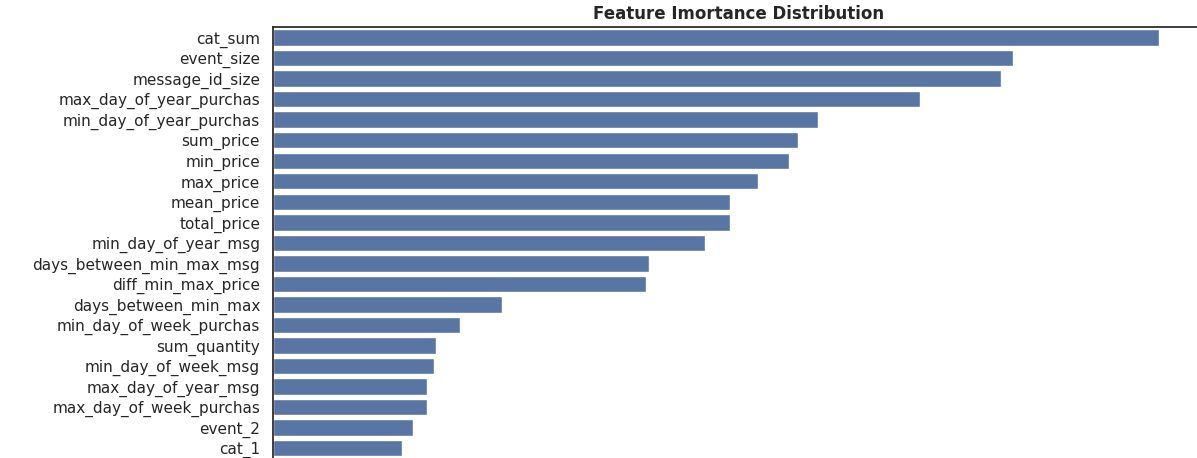


- `cat_sum` - вектор суммы категорий. Нужно обратить внимание на категории, в которых делались покупки;
- `event_size` - количество всех событий, происходящих с маркетинговыми сообщениям;
- `message_id_size` - кол-во отправленных маркетинговых сообщений;
- `max_day_of_year_purchas` - день в году, когда была совершена последняя покупка;
- `min_day_of_year_purchas` - день в году, когда была совершена первая покупка;
- `sum_price` - сумма единиц товара;
- `min_price` - минимальная цена товара;
- `max_price` - максимальная цена товара;
- `mean_price` - средняя цена товаров;
- `total_price` - общая сумма покупок;
- `min_day_of_year_msg` - день в году, когда было отправлено первое сообщение;
- `days_between_min_max_msg` - сколько прошло дней между первой и последней отправки сообщения.